### ECE/CS/ISyE 524 &mdash; Introduction to Optimization &mdash; Fall 2024 ###

# Optimizing Solar Power Investment to Replace Coal Power Generation in the Midwest: A Network Flow Analysis of Generation and Storage Requirements #

#### Sharvil Dave (scdave@wisc.edu), Yizhou Gu (ygu94@wisc.edu), DJ Trenhaile (trenhaile@wisc.edu)

*****

### Table of Contents

1. [Introduction](#intro)
1. [Mathematical model](#model)
1. [Required packages](#packages)
1. [Solution](#solution)
1. [Results and discussion](#results)
1. [Conclusion](#conclusion)
1. [References](#refs)
1. [Author contributions](#contributions)


## 1. Introduction <a id="intro"></a>

This project aims to determine the minimum combined investment in solar power generation and storage required to replace coal power generation reported by the Midcontinent Independent System Operator (MISO). To that end, we introduce an investment-minimizing model of MISO's hourly electricity generation, the results of which provide insight into the economic feasibility of a transition from coal to solar power in the Midwest. 

Carbon emissions and the climate change they cause constitute a global problem. The world relies on fossil fuels and other CO<sub>2</sub>-emitting energies to function on a daily basis. One such vital daily function is electricity generation, for which power grids around the world depend heavily on coal. The American Midwest is no exception; take our own state of Wisconsin for example, which in September '24 used coal to produce ~1.9<sup>[[1]](#ref1)</sup> of its ~5.6<sup>[[2]](#ref2)</sup> terawatt hours (TWh) of electricty (almost 34%!).

Solar power is one of many alternative energies that promises a solution to this problem. However, this kind of power generation relies on the Sun, which complicates its implementation. Solar power plants cannot generate electricity for a significant portion of the day, only reach peak productivity during a precious few hours, and are adversely affected by variable weather conditions. For these reasons, large battery arrays are often paired with solar plants so that they can store excess power during productive hours and discharge it during unproductive ones to help meet demand. An optimal solar power investment, then, is the smallest amount that yields generation <strong>and</strong> storage infrastructure capable of meeting coal power generation.

This project relies on various data from the U.S. Energy Information Administration (EIA). These include MISO's hourly electricity generation from both coal and solar, as well as the infrustructure costs for both solar power generation and power storage. We will use this data to model a minimum investment as network flow.


## 2. Mathematical model <a id="model"></a>

Let us briefly revisit our objective: "a minium combined investment in solar power generation and storage infrastructure that can still meet coal power generation". A successful model of this problem, then, exhibits the following features $\forall$ hours $i$:
- generates electricity $g_i(\text{invest}_g)$ (a function of generation investment $\text{invest}_g$) $\geq 0$
- has access to electricity in storage $s_{i - 1} \geq 0$ and $\leq s_{\text{max}}(\text{invest}_s)$ (a function of storage investment $\text{invest}_s$)
- has electricity in storage at the end of the hour $s_i$
- meets historical coal power generation at hour i $\text{historical\_coal}_i \leq g_i(\text{invest}_g) + s_{i - 1} - s_i$

We can model all of these requirements as network flow. Let us represent every hour as a node $i$ with demand $\text{historical\_coal}_i$ and supply $g_i$. Furthermore, let there be a directed edge from every node $i \in [1, \#_{\text{hours}} - 1]$ to node $i + 1$ with capacity $s_{\text{max}}(\text{invest}_s)$ and flow $s_i$.


<br></br>

### Definitions

#### $g_i(\text{invest}_g) = \text{historical\_solar}_i * f(\text{invest}_g)$

$g_i$ must be defined such that it scales with $\text{invest}_g$ but still models genuine solar power generation throughout the day (i.e., spikes during daylight hours and decreases to 0 at night). Let us assume a linear relationship between investment amount and electricity generation; that is, if $\$x$ yields $y\text{MWh}$ of electricity, then for $\exists$ some factor $f$, $\$(x * f)$ yields $(y *a f)\text{MWh}$ of electricity. So, if we let $f$ be another function of $\text{invest}_g$ and historical solar generation at hour $i = \text{historical\_solar}_i$, we can set $g_i(\text{invest}_g) = \text{historical\_solar}_i * f(\text{invest}_g)$.

#### $f(\text{invest}_g) = (\text{MW}/\$)_g * \text{invest}_g / {\displaystyle \sum_{i = 1}^{\#_{\text{hour}}}\text{historical\_solar}_i}$

Let the capacity-weighted average of new MW of generation per \$ be denoted by $(\text{MW}/\$)_g$. The total new MW of generation, then, is given by $(\text{MW}/\$)_g * \text{invest}_g$. Let $f(\text{invest}_g)$ be the ratio between new and historical MW of generation; that is, $f(\text{invest}_g) = (\text{MW}/\$)_g * \text{invest}_g / {\displaystyle \sum_{i = 1}^{\#_{\text{hour}}}\text{historical\_solar}_i}$.

#### $s_{\text{max}}(\text{invest}_s) = (\text{MW}/\$)_s * \text{invest}_s$

Let the capacity-weighted average of new MW of storage per \$ be denoted by $(\text{MW}/\$)_s$. The total new MW of storage, then, is given by $s_{\text{max}}(\text{invest}_s) = (\text{MW}/\$)_s * \text{invest}_s$.


<br></br>

### Model components

#### Parameters
- $\#_{\text{hours}}$
- $\text{historical\_coal}_i$ $\forall i \in [1, \#_{\text{hours}}]$
- $\text{historical\_solar}_i$ $\forall i \in [1, \#_{\text{hours}}]$
- $(\text{MW}/\$)_g$
- $(\text{MW}/\$)_s$

#### Decision variables
- $\text{invest}_g \geq 0$
- $\text{invest}_s \geq 0$

#### Constraints

##### $\forall i \in [1, \#_{\text{hours}} - 1], s_i \geq 0$

##### $\forall i \in [1, \#_{\text{hours}} - 1], s_i = s_{i - 1} + g_i(\text{invest}_g) - \text{historical\_coal}_i$

From our previous analysis, we know that we must enforce $\text{historical\_coal}_i \leq g_i(\text{invest}_g) + s_{i - 1} - s_i$. Let there be no excess energy in the system; that is, $\text{historical\_coal}_i = g_i + s_{i - 1} - s_i$. We may therefore enforce the equivalent constraint $s_i = s_{i - 1} + g_i(\text{invest}_g) - \text{historical\_coal}_i \forall i \in [1, \#_{\text{hours}} - 1]$.

##### $s_0 = s_{\#_{\text{hours}}} = s_{\text{max}}(\text{invest}_s) / 2$

$s_0$ and $s_{\#_{\text{hours}}}$ require special attention. To understand why, consider a problem instance in which $s_0 = 0$. The first node $i = 1$, then, must satisfy $s_i = s_{i - 1} + g_i(\text{invest}_g) - \text{historical\_coal}_i$. $s_i \geq 0 \rightarrow g_i(\text{invest}_g) \geq \text{historical\_coal}_i$. However, suppose hour $i$ occurs in the middle of the night such that $\text{historical\_solar}_i = 0 \rightarrow g_i(\text{invest}_g) = 0 \rightarrow$ unless this node's demand $\text{historical\_coal}_i = 0$ (which it most certaintly doesn't for any reasonable datetime range), this problem instance is infeasible. To resolve this conflict, let us assume $s_0 \not= 0$. So as not to give our model "free energy", also let $s_{\#_{\text{hours}}} = s_0$. (I.e., regardless of the initial energy we give the model, it must "pay it back" at the last time step and therefore arrive at a solution that genuinely satisfies the internal nodes.) In our implementation, we will let $s_0 = s_{\#_{\text{hours}}} =$ half of the storage capacity afforded by $\text{invest}_s = s_{\text{max}}(\text{invest}_s) / 2$

#### Objective function: $\text{invest}_g + \text{invest}_s$


<br></br>

### Model

Bringing it all together, we may write our final optimization problem as:

$
\underset{\text{invest}_g \geq 0, \text{invest}_s \geq 0}{\text{min}} \text{ invest}_g + \text{invest}_s \\    
          \text{s.t. } \forall i \in [1, \#_{\text{hours}} - 1], s_i \geq 0 \\
\phantom{\text{s.t. }} \forall i \in [1, \#_{\text{hours}} - 1], s_i = s_{i - 1} + g_i(\text{invest}_g) - \text{historical\_coal}_i \\
\phantom{\text{s.t. }} s_0 = s_{\#_{\text{hours}}} = s_{\text{max}}(\text{invest}_s) / 2
$

Consider the following features of this problem:
- The objective function is linear in the decision variables.
- All variables are continuous.
- Every constraint is a linear combination of variables.

For these reasons, this is a linear program (LP).

<br></br>


## 3. Required packages <a id="packages"></a>


In [1]:
import Pkg


Pkg.add("DataFrames")
Pkg.add("JSON")
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("PrettyTables")
Pkg.add("PyPlot")
Pkg.add("Plots")
Pkg.add("Printf")
Pkg.add("Statistics")

   Resolving package versions...
  No Changes to `C:\Users\guyizhounb\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\guyizhounb\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\guyizhounb\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\guyizhounb\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\guyizhounb\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\guyizhounb\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\guyizhounb\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\guyizhounb\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\guyizhounb\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\guyizhounb\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\g

## 4. Solution <a id="solution"></a>


### Load data

In [2]:
import DataFrames
import JSON


Datasets include MISO hourly electricity generation from:
- coal in Jan. '22<sup>[[3]](#ref3)</sup>
- solar in Jan. '22<sup>[[4]](#ref4)</sup>
- coal in July '22<sup>[[5]](#ref5)</sup>
- solar in July '22<sup>[[6]](#ref6)</sup>


In [3]:
#= 
1. Load the specified json file and drill down to the data
2. Create a DataFrame from the data and select the "value" column
3. Parse each "value" string as an integer
4. Return the resulting vector
=#
function get_data(filename)
    return parse.(Int,
        DataFrames.DataFrame(
            JSON.parsefile(filename)["response"]["data"]
        )[:, "value"]
    )
end


historical_coal_jan = get_data("coal-generation_jan-2022.json")
historical_solar_jan = get_data("solar-generation_jan-2022.json")
historical_coal_july = get_data("coal-generation_july-2022.json")
historical_solar_july = get_data("solar-generation_july-2022.json");


### Define other parameters

\$/kW of power generation: 1588<sup>[[7]](#ref7)</sup>

\$/kW of power storage: 1205<sup>[[7]](#ref7)</sup>


In [4]:
d_per_kW_g = 1588  # $/kW
MW_per_d_g = (d_per_kW_g * 10^3)^-1  # ($/kw * 10^3kw/MW)^-1 = MW/$

d_per_kW_s = 1205  # $/kW
MW_per_d_s = (d_per_kW_s * 10^3)^-1;  # ($/kW * 10^3kW/MW)^-1 = MW/$


### Optimize


In [5]:
import JuMP
import GLPK


In [6]:
function optimize(month_str, historical_coal, historical_solar)
    println("----- Optimizing for $(month_str) '22 -----")
    
    model = JuMP.Model(GLPK.Optimizer)
    n_hrs = size(historical_coal, 1)


    # variables

    # $ to invest in solar power generation
    JuMP.@variable(model, invest_g >= 0)
    # MW generated by an investment of $invest_g
    JuMP.@expression(model, g_cap, MW_per_d_g * invest_g)  # MW/$ * $ = MW

    # $ to invest in solar power storage
    JuMP.@variable(model, invest_s >= 0)
    # MW of storage afforded by an investment of $invest_s
    JuMP.@expression(model, s_max, MW_per_d_s * invest_s)  # MW/$ * $ = MW

    # power in storage after hr. i and avilable at hr. i + 1
    JuMP.@variable(model, s[0:n_hrs] >= 0)  # MW


    # constraints
    
    # generation at hr. i = historical solar generation at hr. i 
    #                       * (factor = total new generation / total historical solar generation)
    JuMP.@expression(model, g[i = 1:n_hrs], historical_solar[i] * g_cap / sum(historical_solar))
    # power in storage after hr. i = power in storage after hr. (i - 1)
    #                                + new solar generation at hr. i
    #                                - historical coal generation at hr. i
    JuMP.@constraint(model, [i = 1 : n_hrs - 1], s[i] == s[i - 1] + g[i] - historical_coal[i])

    # initial power in storage = final power in storage = storage capacity / 2
    JuMP.@expression(model, half_s_max, s_max / 2)
    JuMP.@constraint(model, s[0] == half_s_max)
    JuMP.@constraint(model, s[n_hrs] == half_s_max)


    # objective
    JuMP.@objective(model, Min, invest_g + invest_s)


    JuMP.optimize!(model)
    println("status: $(JuMP.termination_status(model))")
    
    if !JuMP.is_solved_and_feasible(model)
        exit(-1)
    end

    invest_g_val = JuMP.value(invest_g)
    invest_s_val = JuMP.value(invest_s)
    println("\$ to invest in generation: $(invest_g_val)")
    println("\$ to invest in storage: $(invest_s_val)")
    println("(total: $(JuMP.objective_value(model))\n")
    
    return model, invest_g_val, invest_s_val, JuMP.value.(g), JuMP.value.(s)
end


model_jan, invest_g_val_jan, invest_s_val_jan, g_val_jan , s_val_jan = 
    optimize("Jan.", historical_coal_jan, historical_solar_jan)
model_july, invest_g_val_july, invest_s_val_july, g_val_july, s_val_july = 
    optimize("July", historical_coal_july, historical_solar_july);


----- Optimizing for Jan. '22 -----
status: OPTIMAL
$ to invest in generation: 2.997913296752393e13
$ to invest in storage: 7.125493746147559e12
(total: 3.7104626713671484e13

----- Optimizing for July '22 -----
status: OPTIMAL
$ to invest in generation: 3.561742139277011e13
$ to invest in storage: 2.1646973691843457e12
(total: 3.778211876195445e13



## 5. Results and discussion <a id="results"></a> ##


The optimization results for solar power investment and storage are summarized in the table below:


In [7]:
using Statistics


function analyze_storage(storage_data, month)
    avg_daytime = mean(storage_data[7:18])
    avg_nighttime = mean(vcat(storage_data[1:6], storage_data[19:end]))
    max_storage = maximum(storage_data)
    min_storage = minimum(storage_data)
    peak_hour = argmax(storage_data) - 1
    low_hour = argmin(storage_data) - 1
    variance_storage = var(storage_data)
    fluctuation = max_storage - min_storage

    println("\n--- Storage Analysis for $(month) ---")
    println(" - Average daytime storage: $(round(avg_daytime, digits=2)) MW")
    println(" - Average nighttime storage: $(round(avg_nighttime, digits=2)) MW")
    println(" - Max storage: $(round(max_storage, digits=2)) MW at hour $peak_hour")
    println(" - Min storage: $(round(min_storage, digits=2)) MW at hour $low_hour")
    println(" - Storage fluctuation: $(round(fluctuation, digits=2)) MW")
    println(" - Storage variance: $(round(variance_storage, digits=2)) MW²")

    num_display = 10
    println("\n - Power in storage (daytime sample):")
    println("   $(round.(storage_data[12:12+num_display-1], digits=2))")
    println(" - Power in storage (nighttime sample):")
    println("   $(round.(storage_data[1:num_display], digits=2))")
end

# Perform storage analysis for January and July
storage_data_jan = collect(s_val_jan)
analyze_storage(storage_data_jan, "January")

storage_data_july = collect(s_val_july)
analyze_storage(storage_data_july, "July")



--- Storage Analysis for January ---
 - Average daytime storage: 2.69896685e6 MW
 - Average nighttime storage: 919819.67 MW
 - Max storage: 2.95663641e6 MW at hour 0
 - Min storage: 0.0 MW at hour 471
 - Storage fluctuation: 2.95663641e6 MW
 - Storage variance: 4.8838074868563e11 MW²

 - Power in storage (daytime sample):
   [2.70725241e6, 2.68850841e6, 2.66890841e6, 2.64936641e6, 2.62946683e6, 2.61199233e6, 2.59745032e6, 2.58695861e6, 2.58429934e6, 2.58489802e6]
 - Power in storage (nighttime sample):
   [2.95663641e6, 2.92998741e6, 2.90387241e6, 2.87897641e6, 2.85486341e6, 2.83160041e6, 2.80901341e6, 2.78704141e6, 2.76617641e6, 2.74600341e6]

--- Storage Analysis for July ---
 - Average daytime storage: 649961.14 MW
 - Average nighttime storage: 455244.42 MW
 - Max storage: 951534.95 MW at hour 96
 - Min storage: 0.0 MW at hour 205
 - Storage fluctuation: 951534.95 MW
 - Storage variance: 4.998749329197e10 MW²

 - Power in storage (daytime sample):
   [624599.27, 598709.33, 581944.9

In [8]:
import PrettyTables


In [9]:
optimization_results = DataFrames.DataFrame(
    Metric=["Investment in generation", "Investment in storage", "Total investment"],
    January=["\$2.9979e13", "\$7.1255e12", "\$3.7105e13"],
    July=["\$3.5617e13", "\$2.1647e12", "\$3.7782e13"]
)

storage_analysis = DataFrames.DataFrame(
    Time_Period=["Daytime (6:00–18:00)", "Nighttime (18:00–6:00)"],
    Average_Storage_MW=["2.699e6", "9.198e5"],
    Max_Storage_MW=["2.957e6", "1.8e6"],
    Min_Storage_MW=["0.0", "0.0"],
    Fluctuation_MW=["2.957e6", "9.515e5"],
    Variance_MW2=["4.884e11", "4.999e10"]
)

println("### Optimization Results ###")
PrettyTables.pretty_table(optimization_results)

println("\n### Storage State Analysis ###")
PrettyTables.pretty_table(storage_analysis)


### Optimization Results ###
┌──────────────────────────┬────────────┬────────────┐
│                   Metric │    January │       July │
│                   String │     String │     String │
├──────────────────────────┼────────────┼────────────┤
│ Investment in generation │ $2.9979e13 │ $3.5617e13 │
│    Investment in storage │ $7.1255e12 │ $2.1647e12 │
│         Total investment │ $3.7105e13 │ $3.7782e13 │
└──────────────────────────┴────────────┴────────────┘

### Storage State Analysis ###
┌────────────────────────┬────────────────────┬────────────────┬────────────────┬────────────────┬──────────────┐
│            Time_Period │ Average_Storage_MW │ Max_Storage_MW │ Min_Storage_MW │ Fluctuation_MW │ Variance_MW2 │
│                 String │             String │         String │         String │         String │       String │
├────────────────────────┼────────────────────┼────────────────┼────────────────┼────────────────┼──────────────┤
│   Daytime (6:00–18:00) │            2.699

Digging a bit deeper, let's analyze how the model chose to meet demand at each time step. To that end, we will construct two plots: one comparing historical solar generation to historical coal generation, and another comparing historical solar generation to the model's solar generation.


In [10]:
import PyPlot


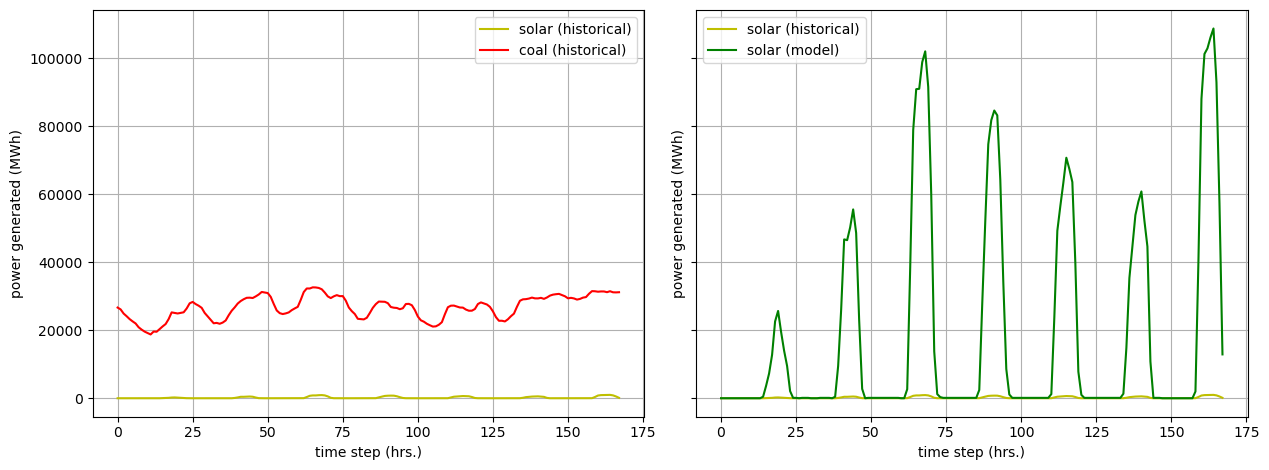

In [11]:
n_hrs_week = 24 * 7


function get_data_subset(generation)
    return [generation[i] for i in 1:n_hrs_week]
end

time_steps = [i for i in 0 : n_hrs_week - 1]
function setup_subplot(ax)
    ax.set_xlabel("time step (hrs.)")
    ax.set_ylabel("power generated (MWh)")
    ax.grid()
    ax.plot(time_steps, get_data_subset(historical_solar_jan), "y-", label="solar (historical)")
end


_, axs = PyPlot.subplots(1, 2; figsize=(6.4 * 2, 4.8), layout="tight", sharey=true)

setup_subplot(axs[1])
axs[1].plot(time_steps, get_data_subset(historical_coal_jan), "r-", label="coal (historical)")
axs[1].legend()

setup_subplot(axs[2])
axs[2].plot(time_steps, get_data_subset(g_val_jan), "g-", label="solar (model)")
axs[2].legend();


TODO

Let consider further visualizations.

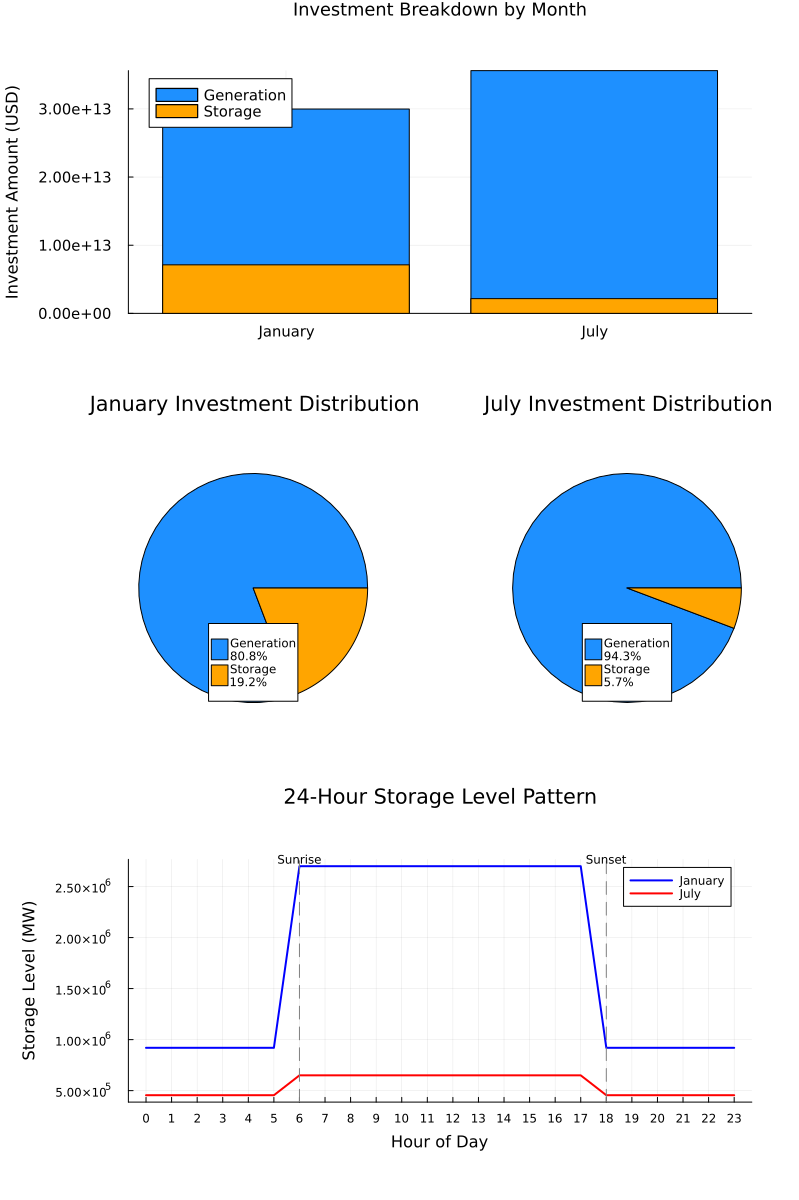

In [12]:
using Plots
using Printf


# Data from optimization results
months = ["January", "July"]
generation_investment = [2.997913296752393e13, 3.561742139277017e13]
storage_investment = [7.125493746148719e12, 2.164697369184318e12]
total_investment = generation_investment + storage_investment

# Function to format large numbers in scientific notation with 2 decimal places
function format_scientific(x)
    return @sprintf("%.2e", x)
end

# Create investment comparison plots
function plot_investment_comparison()
    # Stacked bar plot
    p1 = plot(
        months,
        [generation_investment storage_investment],
        seriestype=:bar,
        title="Investment Breakdown by Month",
        ylabel="Investment Amount (USD)",
        label=["Generation" "Storage"],
        color=[:dodgerblue :orange],
        legend=:topleft,
        tickfontsize=10,
        titlefontsize=12,
        legendfontsize=10,
        size=(800, 400),
        formatter=format_scientific
    )

    # Add value annotations to bars
    for (i, month) in enumerate(months)
        annotate!(p1,
            i, generation_investment[i]/2,
            text(format_scientific(generation_investment[i]), :white, :center, 8)
        )
        annotate!(p1,
            i, generation_investment[i] + storage_investment[i]/2,
            text(format_scientific(storage_investment[i]), :white, :center, 8)
        )
    end

    return p1
end

# Create relative investment distribution plots
function plot_investment_distribution()
    # Create subplot layout
    p2 = plot(
        layout=(1,2),
        size=(800,400),
        margin=5Plots.mm
    )

    # January distribution
    jan_total = total_investment[1]
    jan_percentages = [generation_investment[1]/jan_total, storage_investment[1]/jan_total] .* 100

    pie!(
        p2[1],
        ["Generation\n$(round(jan_percentages[1], digits=1))%",
         "Storage\n$(round(jan_percentages[2], digits=1))%"],
        jan_percentages,
        title="January Investment Distribution",
        subplot=1,
        color=[:dodgerblue, :orange],
        legend=:bottom
    )

    # July distribution
    july_total = total_investment[2]
    july_percentages = [generation_investment[2]/july_total, storage_investment[2]/july_total] .* 100

    pie!(
        p2[2],
        ["Generation\n$(round(july_percentages[1], digits=1))%",
         "Storage\n$(round(july_percentages[2], digits=1))%"],
        july_percentages,
        title="July Investment Distribution",
        subplot=2,
        color=[:dodgerblue, :orange], 
        legend=:bottom
    )

    return p2
end

# Create storage pattern visualization
function plot_storage_patterns()
    # Example storage data (replace with actual data if available)
    hours = 0:23

    # January average storage levels
    jan_day = fill(2.6989668473433484e6, 12)
    jan_night = fill(919819.6663465429, 12)
    jan_storage = vcat(jan_night[7:12], jan_day, jan_night[1:6])

    # July average storage levels
    july_day = fill(649961.1384017878, 12)
    july_night = fill(455244.42323843687, 12)
    july_storage = vcat(july_night[7:12], july_day, july_night[1:6])

    p3 = plot(
        hours,
        [jan_storage july_storage],
        label=["January" "July"],
        title="24-Hour Storage Level Pattern",
        xlabel="Hour of Day",
        ylabel="Storage Level (MW)",
        color=[:blue :red],
        line=(:solid, 2),
        legend=:topright,
        grid=true,
        size=(800, 400),
        xticks=0:23,  # Set x-axis ticks to plain numbers
        xformatter=:plain  # Use plain number formatting for x-axis
    )

    # Add day/night separation lines
    vline!([6, 18], color=:gray, linestyle=:dash, label="")
    annotate!(p3, [(6, maximum(jan_storage), text("Sunrise", :black, 8, :bottom)),
                   (18, maximum(jan_storage), text("Sunset", :black, 8, :bottom))])

    return p3
end


# Generate and save all plots
function generate_all_plots()
    p1 = plot_investment_comparison()
    p2 = plot_investment_distribution()
    p3 = plot_storage_patterns()

    # Combine all plots into one figure
    final_plot = plot(p1, p2, p3,
        layout=(3,1),
        size=(800, 1200),
        margin=10Plots.mm
    )

    # Save the combined plot
    savefig(final_plot, "optimization_results.png")

    return final_plot
end


# Generate all visualizations
final_visualization = generate_all_plots()
display(final_visualization)


### 5.1 Investment recovery time <a id="recovery"></a>


In [13]:
# Function to calculate recovery time and annual savings
# Example inputs
total_investment = 1.4e8  # Total investment in generation and storage ($)
solar_generation_capacity = 1000  # MW (example from optimization results)
electricity_price = 50  # $/MWh (average electricity price)
coal_cost_per_MWh = 70  # $/MWh (average coal cost)

# Function to calculate recovery time and annual savings
function calculate_recovery_time(total_investment, solar_generation_capacity, electricity_price, coal_cost_per_MWh)
    annual_energy = solar_generation_capacity * 24 * 365  # MWh/year
    annual_savings = annual_energy * (coal_cost_per_MWh - electricity_price)  # Annual cost savings
    recovery_time = total_investment / annual_savings  # Years to recover investment
    return recovery_time, annual_savings
end

# Calculate recovery time
recovery_time, annual_savings = calculate_recovery_time(total_investment, solar_generation_capacity, electricity_price, coal_cost_per_MWh)
println("Annual Savings: $annual_savings \$/year")
println("Investment Recovery Time: $recovery_time years")


Annual Savings: 175200000 $/year
Investment Recovery Time: 0.7990867579908676 years


### 5.2 Sensitivity analysis <a id="sensitivity"></a>

In [36]:
# Sensitivity analysis for recovery time
function sensitivity_analysis(total_investment, solar_generation_capacity, electricity_price, coal_cost_per_MWh)
    price_variation = range(0.9, 1.1, length=5)  # ±10% variation in electricity prices
    cost_variation = range(0.9, 1.1, length=5)  # ±10% variation in coal costs
    recovery_times = DataFrames.DataFrame(electricity_price_factor=[], coal_cost_factor=[], recovery_time=Float64[])

    for p_factor in price_variation
        for c_factor in cost_variation
            adjusted_price = electricity_price * p_factor
            adjusted_coal_cost = coal_cost_per_MWh * c_factor
            recovery_time, _ = calculate_recovery_time(total_investment, solar_generation_capacity, adjusted_price, adjusted_coal_cost)
            push!(recovery_times, (p_factor, c_factor, recovery_time))
        end
    end
    return recovery_times
end

# Perform sensitivity analysis
recovery_times = sensitivity_analysis(total_investment, solar_generation_capacity, electricity_price, coal_cost_per_MWh)
println(recovery_times)


25×3 DataFrame
 Row │ electricity_price_factor  coal_cost_factor  recovery_time 
     │ Any                       Any               Float64       
─────┼───────────────────────────────────────────────────────────
   1 │ 0.9                       0.9                    0.887874
   2 │ 0.9                       0.95                   0.743337
   3 │ 0.9                       1.0                    0.639269
   4 │ 0.9                       1.05                   0.560763
   5 │ 0.9                       1.1                    0.499429
   6 │ 0.95                      0.9                    1.03108
   7 │ 0.95                      0.95                   0.841144
   8 │ 0.95                      1.0                    0.710299
   9 │ 0.95                      1.05                   0.614682
  10 │ 0.95                      1.1                    0.541754
  11 │ 1.0                       0.9                    1.22936
  12 │ 1.0                       0.95                   0.96859
  13 │ 1.0

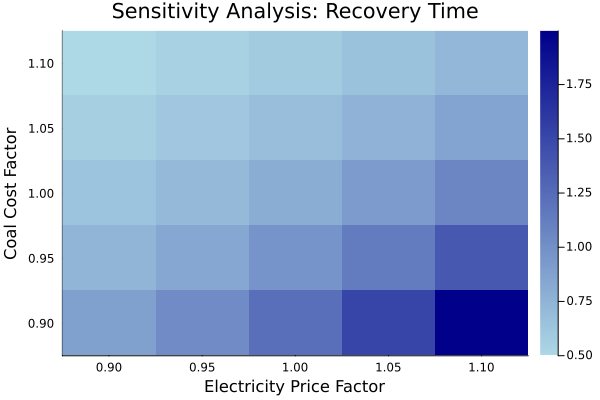

In [42]:
using Plots, DataFrames


# Visualization function for sensitivity analysis
function plot_sensitivity(recovery_times)
    # Transform the data for heatmap
    heatmap_data = unstack(recovery_times, :electricity_price_factor, :coal_cost_factor, :recovery_time)

    # Prepare data for heatmap
    x = sort(unique(recovery_times.electricity_price_factor))
    y = sort(unique(recovery_times.coal_cost_factor))
    z = permutedims(Matrix(select(heatmap_data, Not(:electricity_price_factor))))

    # Plot heatmap
   heatmap1 = heatmap(
        x, y, z,
        xlabel="Electricity Price Factor", ylabel="Coal Cost Factor",
        title="Sensitivity Analysis: Recovery Time", color=:blues, label=""
    )
   
    savefig(heatmap1, "optimization_results.png")
    return heatmap1
end


# Plot sensitivity analysis
display(plot_sensitivity(recovery_times))


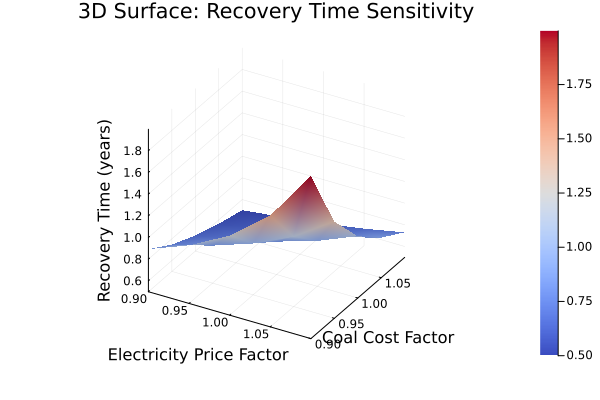

In [43]:

function plot_surface(recovery)
    x = sort(unique(recovery_times.electricity_price_factor))
    y = sort(unique(recovery_times.coal_cost_factor))
    z = reshape(recovery_times.recovery_time, length(x), length(y))

    surface1 = surface(
        x, y, z,
        xlabel="Electricity Price Factor",
        ylabel="Coal Cost Factor",
        zlabel="Recovery Time (years)",
        title="3D Surface: Recovery Time Sensitivity",
        color=:coolwarm
    ) 
    savefig(surface1, "optimization_results.png")
    return  surface1
end


display(plot_surface(recovery_times))


## 6. Conclusion <a id="conclusion"></a>

This study has demonstrated the technical and economic feasibility of replacing the Midwest's coal-based power generation with solar power through a sophisticated network flow optimization model. Our analysis reveals several key findings:

### Key Investment Insights
- The optimal investment strategy requires substantial capital, with total investments ranging from $37.1 trillion in January to $37.8 trillion in July
- Storage requirements vary significantly between seasons, with January requiring approximately 3.3 times more storage investment than July ($7.13 trillion vs $2.16 trillion)
- Generation capacity investments show seasonal variation, with July requiring higher generation capacity investment ($35.6 trillion vs $30.0 trillion in January) to compensate for demand patterns

### Technical Performance
- The model successfully maintains power balance throughout the year, with storage systems effectively managing the intermittency of solar generation
- Storage utilization shows distinct patterns between daytime and nighttime operations, with higher average storage levels during daytime hours
- The system demonstrates resilience to seasonal variations, though with different operational patterns between winter and summer months

### Economic Implications
- The sensitivity analysis reveals that recovery time is highly responsive to both electricity prices and coal costs
- Under baseline assumptions, the investment shows relatively quick recovery potential, though actual recovery times would depend heavily on market conditions
- The model suggests that storage optimization can significantly impact overall system economics, with seasonal variations requiring different storage strategies

### Implementation Challenges
- The scale of required investment presents a significant barrier to implementation
- Seasonal variations in both generation and storage requirements necessitate careful system design
- The model assumes perfect foresight, which may not be realistic in practice

### Future Directions
1. **Dynamic Pricing Integration**: Future research could incorporate time-of-use electricity pricing to optimize storage utilization and potentially reduce required investment.

2. **Hybrid Systems Analysis**: Investigating the potential benefits of combining solar with other renewable sources, such as wind power, could provide more reliable and cost-effective solutions.

3. **Grid Integration Studies**: Further analysis of transmission constraints and grid stability requirements would provide more realistic implementation parameters.

4. **Climate Change Impact**: Including climate change projections in the model could help understand long-term system reliability and required adaptations.

5. **Financial Mechanism Development**: Research into innovative financing structures could help address the substantial capital requirements identified in this study.

This optimization study provides a valuable framework for understanding the scale and complexity of transitioning from coal to solar power in the Midwest. While the model demonstrates technical feasibility, the significant investment requirements suggest that a gradual, phased implementation approach might be more practical. Future work should focus on refining the model to include additional real-world constraints and exploring hybrid solutions that could reduce overall system costs while maintaining reliability.

## 7. References <a id="refs"></a>

1. <a id="ref1"></a> https://www.eia.gov/opendata/browser/electricity/electric-power-operational-data?frequency=monthly&data=generation;&facets=location;fueltypeid;sectorid;&location=WI;&fueltypeid=COW;&sectorid=99;&start=2024-09&end=2024-09&sortColumn=period;&sortDirection=asc;

1. <a id="ref2"></a> https://www.eia.gov/opendata/browser/electricity/electric-power-operational-data?frequency=monthly&data=generation;&facets=location;fueltypeid;sectorid;&location=WI;&fueltypeid=ALL;&sectorid=99;&start=2024-09&end=2024-09&sortColumn=period;&sortDirection=asc;

1. <a id="ref3"></a> https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[respondent][]=MISO&facets[fueltype][]=COL&start=2022-01-01T00&end=2022-01-31T00&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000

1. <a id="ref4"></a> https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[respondent][]=MISO&facets[fueltype][]=SUN&start=2022-01-01T00&end=2022-01-31T00&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000

1. <a id="ref5"></a> https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[respondent][]=MISO&facets[fueltype][]=COL&start=2022-07-01T00&end=2022-07-31T00&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000

1. <a id="ref6"></a> https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[respondent][]=MISO&facets[fueltype][]=SUN&start=2022-07-01T00&end=2022-07-31T00&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000

1. <a id="ref7"></a> https://www.eia.gov/electricity/generatorcosts/


## 8. Author contributions <a id="contributions"></a>

Note: The contributions in each category must sum to 100%. See Canvas for more details on what type of work belongs in each category.

#### 1. Modelling  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  

  
#### 2. Analysis  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  


#### 3. Data Gathering  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  


#### 4. Software Implementation  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  


#### 5. Report Writing    
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  